# MultiMAE: Multi-modal Multi-task Masked Autoencoders


In [1]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from functools import partial
import torch
import torchvision.transforms.functional as TF

from multimae.models.multimae import pretrain_multimae_base
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Mask2Former and detectron2 dependencies for semantic segmentation pseudo labeling
from detectron2.utils.visualizer import ColorMode, Visualizer
from detectron2.data import MetadataCatalog
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.projects.deeplab import add_deeplab_config
coco_metadata = MetadataCatalog.get("coco_2017_val_panoptic")
from mask2former import add_maskformer2_config

# DPT dependencies for depth pseudo labeling
from dpt.models import DPTDepthModel
from pipelines.utils.data_utils import preprocess_multimae_inputs_in_batch
from multimae.models.input_adapters import PatchedInputAdapter, SemSegInputAdapter
from multimae.models.output_adapters import SpatialOutputAdapter
from multimae.models.multimae import pretrain_multimae_base
from multimae.utils.data_constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

torch.set_grad_enabled(False)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

flightmare_path = Path(os.environ['FLIGHTMARE_PATH'])
multimae_path = flightmare_path.parent / "vision_backbones/MultiMAE"

### 2.2 Pseudo labeling model setup

In [2]:
# Initialize Omnidata depth model

omnidata_ckpt = torch.load(multimae_path / 'pretrained_models/omnidata_rgb2depth_dpt_hybrid.pth', map_location='cpu')
depth_model = DPTDepthModel()
depth_model.load_state_dict(omnidata_ckpt)
depth_model = depth_model.to(device).eval()

def predict_depth(img):
  depth_model_input = (img.unsqueeze(0) - 0.5) / 0.5
  return depth_model(depth_model_input.to(device))

In [3]:
# COCO Mask2Former

cfg = get_cfg()
add_deeplab_config(cfg)
add_maskformer2_config(cfg)
cfg.merge_from_file(multimae_path.parent / "Mask2Former/configs/coco/panoptic-segmentation/swin/maskformer2_swin_small_bs16_50ep.yaml")
cfg.MODEL.WEIGHTS = 'https://dl.fbaipublicfiles.com/maskformer/mask2former/coco/panoptic/maskformer2_swin_small_bs16_50ep/model_final_a407fd.pkl'
cfg.MODEL.MASK_FORMER.TEST.SEMANTIC_ON = True
cfg.MODEL.MASK_FORMER.TEST.INSTANCE_ON = True
cfg.MODEL.MASK_FORMER.TEST.PANOPTIC_ON = True
semseg_model = DefaultPredictor(cfg)

def predict_semseg(img):
  return semseg_model(255*img.permute(1,2,0).numpy())['sem_seg'].argmax(0)

def plot_semseg(img, semseg, ax):
  v = Visualizer(img.permute(1,2,0), coco_metadata, scale=1.2, instance_mode=ColorMode.IMAGE_BW)
  semantic_result = v.draw_sem_seg(semseg.cpu()).get_image()
  ax.imshow(semantic_result)

Weight format of MultiScaleMaskedTransformerDecoder have changed! Please upgrade your models. Applying automatic conversion now ...


### 2.3  MultiMAE model setup

In [4]:
DOMAIN_CONF = {
    'rgb': {
        'input_adapter': partial(PatchedInputAdapter, num_channels=3, stride_level=1),
        'output_adapter': partial(SpatialOutputAdapter, num_channels=3, stride_level=1),
    },
    'depth': {
        'input_adapter': partial(PatchedInputAdapter, num_channels=1, stride_level=1),
        'output_adapter': partial(SpatialOutputAdapter, num_channels=1, stride_level=1),
    },
    'semseg': {
        'input_adapter': partial(SemSegInputAdapter, num_classes=133,
                                 dim_class_emb=64, interpolate_class_emb=False, stride_level=4),
        'output_adapter': partial(SpatialOutputAdapter, num_channels=133, stride_level=4),
    },
}
DOMAINS = ['rgb', 'depth', 'semseg']

input_adapters = {
    domain: dinfo['input_adapter'](
        patch_size_full=16,
    )
    for domain, dinfo in DOMAIN_CONF.items()
}
output_adapters = {
    domain: dinfo['output_adapter'](
        patch_size_full=16,
        dim_tokens=256,
        use_task_queries=True,
        depth=2,
        context_tasks=DOMAINS,
        task=domain
    )
    for domain, dinfo in DOMAIN_CONF.items()
}

multimae = pretrain_multimae_base(
    input_adapters=input_adapters,
    output_adapters=output_adapters,
)

CKPT_URL = 'https://github.com/EPFL-VILAB/MultiMAE/releases/download/pretrained-weights/multimae-b_98_rgb+-depth-semseg_1600e_multivit-afff3f8c.pth'
ckpt = torch.hub.load_state_dict_from_url(CKPT_URL, map_location='cpu')
multimae.load_state_dict(ckpt['model'], strict=False)
multimae = multimae.to(device).eval()


### 2.4 Plotting utils

In [5]:
from multimae.utils.plot_utils import plot_predictions

## 3 MultiMAE prediction

Try out MultiMAE by loading any RGB image from a URL using this form:

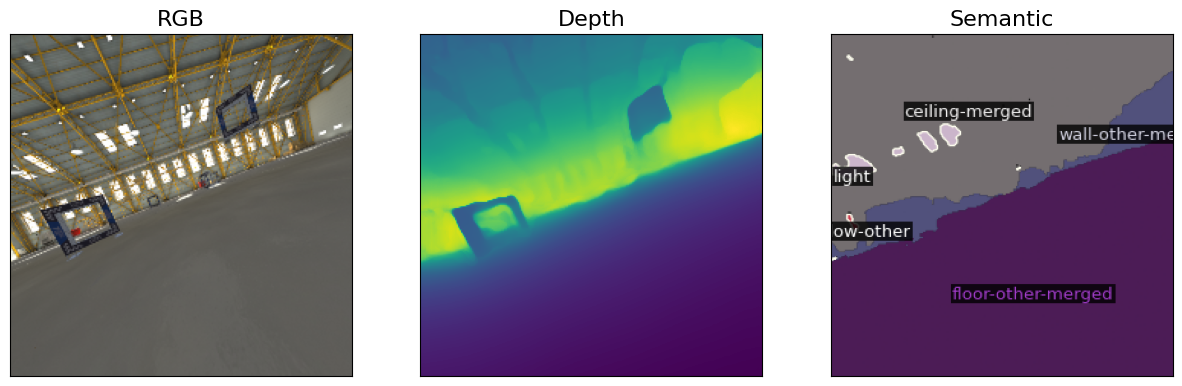

tensor(0.4112, device='cuda:0') tensor(0.0473, device='cuda:0')
0.1517106 0.0010403295


In [14]:
#@title Load image and display pseudo labels

# image_url = "https://i.imgur.com/AptRF3J.jpg" #@param {"type": "string"}

# Download image from the specified URL
# !wget $image_url -q -O input.jpg
sample_img_path = multimae_path / 'samples/rgb.png'
im = Image.open(str(sample_img_path))

# Center crop and resize RGB
image_size = 224 # Train resolution
img = TF.center_crop(TF.to_tensor(im), min(im.size))
img = TF.resize(img, image_size)

# Predict depth and semseg
depth = predict_depth(img)
semseg = predict_semseg(img)

# Plot loaded RGB image and pseudo labeled depth and semseg
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax[0].imshow(img.permute(1,2,0))
ax[0].set_title('RGB', fontsize=16)
ax[1].imshow(depth[0].cpu())
ax[1].set_title('Depth', fontsize=16)
plot_semseg(img, semseg, ax[2])
ax[2].set_title('Semantic', fontsize=16)

for a in ax:
  a.set_xticks([])
  a.set_yticks([])

plt.show()

print(depth.max(), depth.min())

depth_gt = np.load(str(multimae_path / 'samples/depth.npy'))
depth_gt /= 100
print(depth_gt.max(), depth_gt.min())

In [7]:
# Pre-process RGB, depth and semseg to the MultiMAE input format

input_dict = {}

# Normalize RGB
input_dict['rgb'] = TF.normalize(img, mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD).unsqueeze(0)

# Normalize depth robustly
trunc_depth = torch.sort(depth.flatten())[0]
trunc_depth = trunc_depth[int(0.1 * trunc_depth.shape[0]): int(0.9 * trunc_depth.shape[0])]
depth = (depth - trunc_depth.mean()[None,None,None]) / torch.sqrt(trunc_depth.var()[None,None,None] + 1e-6)
input_dict['depth'] = depth.unsqueeze(0)

# Downsample semantic segmentation
stride = 4
semseg = TF.resize(semseg.unsqueeze(0), (semseg.shape[0] // stride, semseg.shape[1] // stride), interpolation=TF.InterpolationMode.NEAREST)
input_dict['semseg'] = semseg

print(input_dict["rgb"].shape)
print(input_dict["depth"].shape)
print(input_dict["semseg"].shape)
    
# To GPU
input_dict = {k: v.to(device) for k,v in input_dict.items()}

torch.Size([1, 3, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 56, 56])


Make predictions with a random mask. The mask is sampled during the forward pass and returned, as an output, so you can modify it manually and pass as input (see example below).

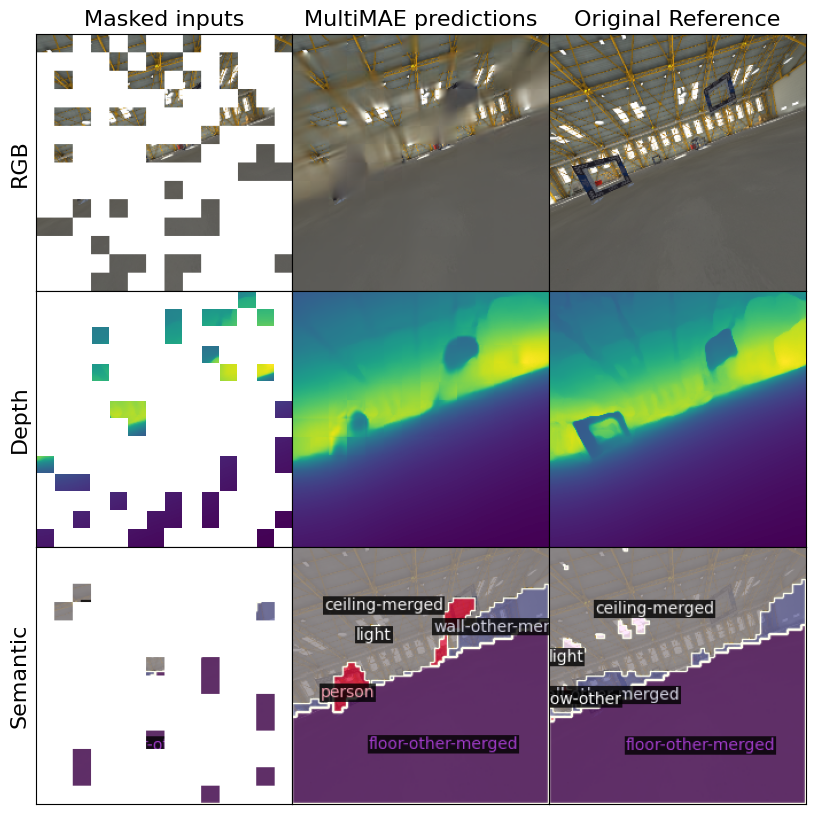

In [8]:
torch.manual_seed(1) # change seed to resample new mask
num_encoded_tokens = 98 # the number of visible tokens
alphas = 1.0 # Dirichlet concentration parameter

preds, masks = multimae.forward(
    input_dict, 
    mask_inputs=True, # True if forward pass should sample random masks
    num_encoded_tokens=num_encoded_tokens,
    alphas=alphas
)

preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in masks.items()}

res = plot_predictions(input_dict, preds, masks)

You can modify the sampled mask and use it as input. Let us, for example, mask out all the depth and semantic inputs, and only keep the RGB patches.

In [9]:
masks['depth'].fill_(1);
masks['semseg'].fill_(1);

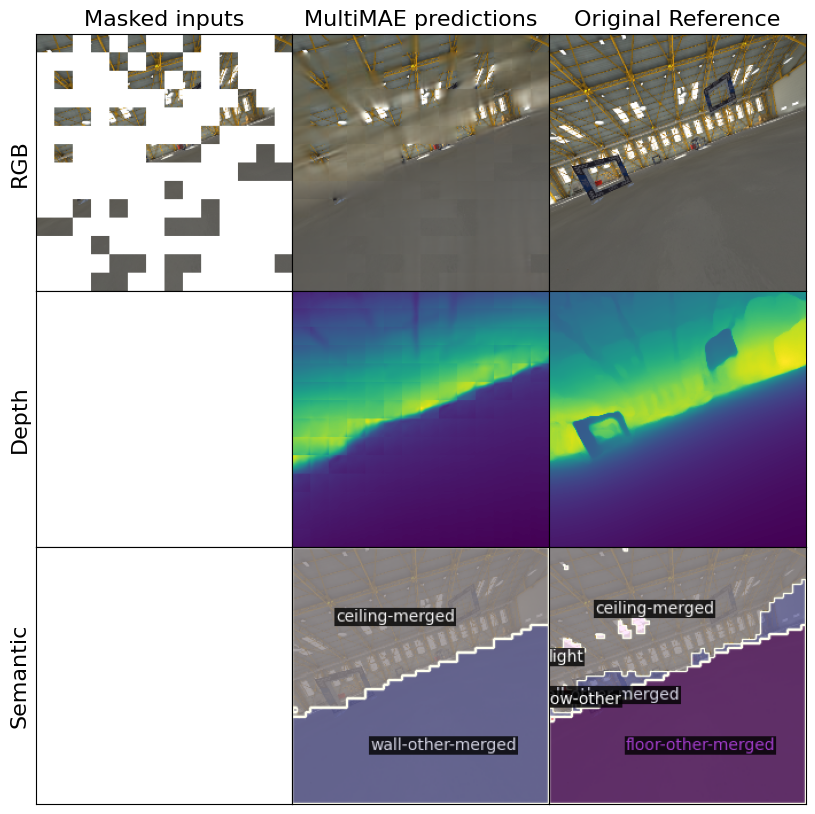

In [10]:
task_masks = {k: v.to(device) for k, v in masks.items()}

preds, masks = multimae.forward(
    input_dict, 
    mask_inputs=True,
    task_masks=task_masks
)

preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in masks.items()}

res = plot_predictions(input_dict, preds, masks)

You can also define the mask yourself

* 1 - masked patch
* 0 - non-masked

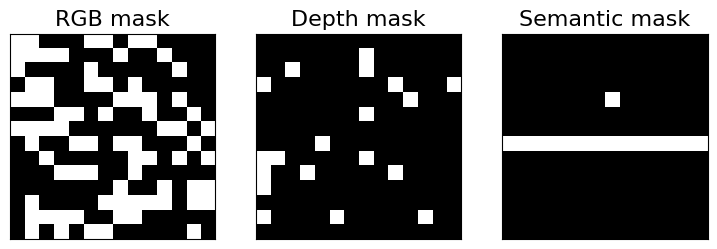

In [11]:
mask = {}

mask['rgb'] = np.array([
    [0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1],
    [0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1],
    [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
    [1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1],
    [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1],
    [1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0],
    [1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1],
    [1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0],
    [1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0],
    [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0],
    [1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1],
    [1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1]
])


mask['depth'] = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
    [1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
])

mask['semseg'] = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
])

plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
plt.imshow(1-mask['rgb'], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('RGB mask', size=16)

plt.subplot(1, 3, 2)
plt.imshow(1-mask['depth'], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Depth mask', size=16)

plt.subplot(1, 3, 3)
plt.imshow(1-mask['semseg'], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.title('Semantic mask', size=16);



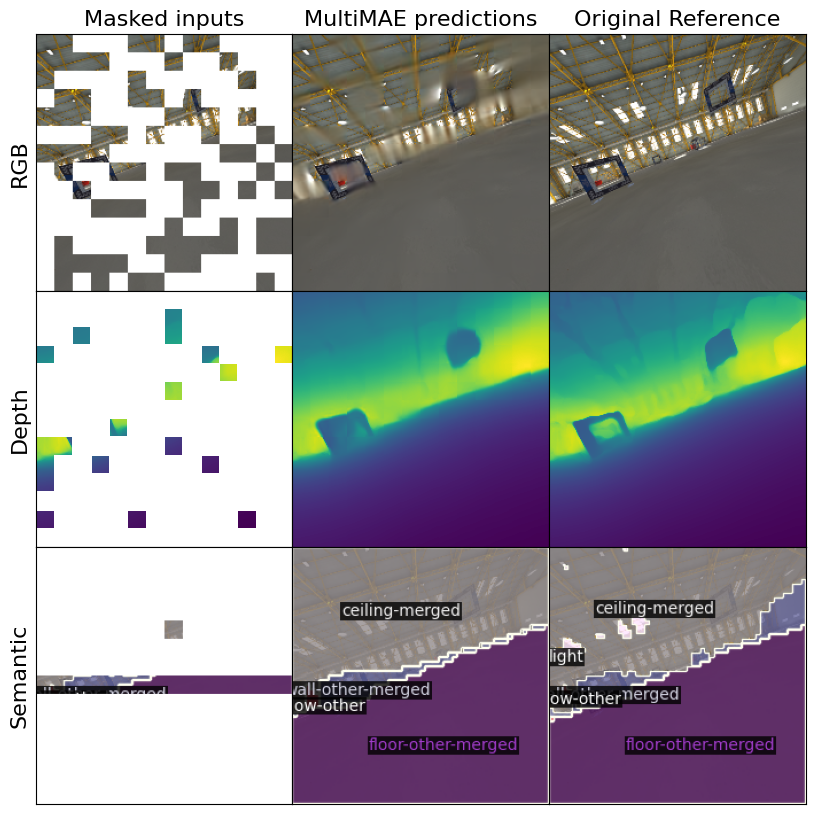

In [12]:
task_masks = {k: torch.LongTensor(v).flatten()[None].to(device) for k, v in mask.items()}
preds, masks = multimae.forward(
    input_dict, 
    mask_inputs=True,
    task_masks=task_masks
)

preds = {domain: pred.detach().cpu() for domain, pred in preds.items()}
masks = {domain: mask.detach().cpu() for domain, mask in masks.items()}

res = plot_predictions(input_dict, preds, masks)